In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_classification
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_score
from utils import load_dataset, extract_final_losses, plot_training_error_curves, compute_performance_metrics, print_metrics_summary

In [26]:
x_train, x_test, y_train, y_test = load_dataset()

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_train)

(382646, 243) (382646, 2)
(97300, 243) (97300, 2)
[[1. 0. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 1. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 0. 1. 0.]
 [1. 1. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 1. 0. 0.]]


In [27]:
epochs = 10000
batch_size = 512
patience = 10
validation_fraction = 0.33

In [28]:
first_mlp = MLPClassifier(max_iter=epochs, batch_size=batch_size, early_stopping=True, n_iter_no_change=patience, validation_fraction=validation_fraction, activation='identity', random_state=42, hidden_layer_sizes=50)

In [29]:
second_mlp = MLPClassifier(max_iter=epochs, batch_size=batch_size, early_stopping=True, n_iter_no_change=patience, validation_fraction=validation_fraction, activation='tanh', random_state=42, hidden_layer_sizes=50)

In [30]:
third_mlp = MLPClassifier(max_iter=epochs, batch_size=batch_size, early_stopping=True, n_iter_no_change=patience, validation_fraction=validation_fraction, activation='logistic', random_state=42, hidden_layer_sizes=50)

In [36]:
base_lr = third_mlp
ovr = OneVsRestClassifier(base_lr)
ovr.fit(x_train, y_train)
y_pred_ovr = ovr.predict(x_test)
ovr_jaccard_score = jaccard_score(y_test, y_pred_ovr, average='samples')

In [38]:
# Fit an ensemble of logistic regression classifier chains and take the
# take the average prediction of all the chains.
chains = [ClassifierChain(first_mlp, order='random', random_state=0), ClassifierChain(second_mlp, order='random', random_state=1), ClassifierChain(third_mlp, order='random', random_state=2)]

for chain in chains:
    chain.fit(x_train, y_train)

y_pred_chains = np.array([chain.predict(x_test) for chain in
                          chains])
chain_jaccard_scores = [jaccard_score(y_test, y_pred_chain >= .5,
                                      average='samples')
                        for y_pred_chain in y_pred_chains]

y_pred_ensemble = y_pred_chains.mean(axis=0)

In [47]:
y_pred_proba_chains = np.array([chain.predict_proba(x_test) for chain in
                          chains])
chain_jaccard_proba_scores = [jaccard_score(y_test, y_pred_proba_chain >= .5,
                                      average='samples')
                        for y_pred_proba_chain in y_pred_proba_chains]

y_pred_proba_ensemble = y_pred_proba_chains.mean(axis=0)

In [41]:
ensemble_jaccard_score = jaccard_score(y_test,
                                       y_pred_ensemble >= .5,
                                       average='samples')
model_scores = [ovr_jaccard_score] + chain_jaccard_scores
model_scores.append(ensemble_jaccard_score)

model_names = ('Independent',
               'MLP 1',
               'MLP 2',
               'MLP 3',
               'Ensemble')

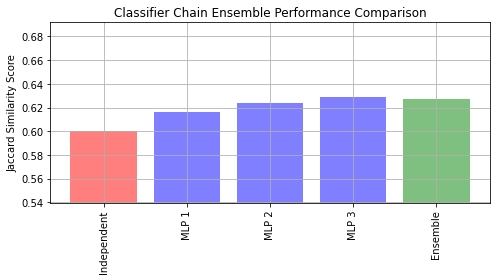

In [44]:
x_pos = np.arange(len(model_names))

# Plot the Jaccard similarity scores for the independent model, each of the
# chains, and the ensemble (note that the vertical axis on this plot does
# not begin at 0).

fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title('Classifier Chain Ensemble Performance Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation='vertical')
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([min(model_scores) * .9, max(model_scores) * 1.1])
colors = ['r'] + ['b'] * len(chain_jaccard_scores) + ['g']
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()

[0 0 0 ... 1 1 1]
[1 0 0 ... 0 1 1]


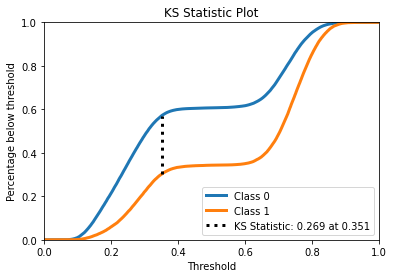


Accuracy:         0.6274
Recall:           0.6595
Precision:        0.4709
F1:               0.5495
AUROC:            0.6877
AUPR:             0.5160


In [48]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, y_pred_ensemble, y_pred_proba_ensemble)
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)